In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import LSTM, Activation, Dense , Dropout
from keras.optimizers import Adam,SGD
from keras.callbacks import EarlyStopping , LearningRateScheduler
import keras.backend as K
from keras.initializers import RandomUniform
from keras import metrics , regularizers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf


Using TensorFlow backend.


In [2]:
def splitData(X,rate):
    train = X[:int(X.shape[0]*rate)]
    val = X[int(X.shape[0]*rate):]
    return train, val

def periods(data,days,data_date=None,f_days=10):
    y = []
    x = []
    p_dates = []
    for i in range(0,len(data),days):
        if i+days+f_days>=len(data)-1:
            break
        x.append(data[i:i+days])
        if type(data_date) != type(None):
            p_dates.append(data_date[i:i+days])
            print(p_dates[-1])
        if data[i+days+f_days][0] > data[i+days-1][0]:
            y.append(1)
        else:
            y.append(0)
        print(data_date[i+days-1],data_date[i+days+f_days])
    return np.array(x),np.array(y),p_dates
def unperiods(data,days):
    l = []
    for a in data:
        l.extend(a)
    return l
df = pd.read_csv("data/2330_indicators.csv").drop(range(11))
print(np.array(df.values).shape)

(6232, 10)


In [3]:
p_days = 20
sc = MinMaxScaler()
#移除前11筆因累積計算技術指標為0
data_sc = sc.fit_transform(df.drop(['date'],axis=1).values)
x,y,p_dates = periods(data_sc,p_days,df.iloc[:,[0]].values)
print(x.shape)
X_train , X_val = splitData(x,0.8)
Y_train , Y_val = splitData(y,0.8)
xx,pd = splitData(np.array(p_dates),0.8)
p_date = unperiods(pd,p_days)

[['83/09/17']
 ['83/09/21']
 ['83/09/22']
 ['83/09/23']
 ['83/09/24']
 ['83/09/26']
 ['83/09/27']
 ['83/09/29']
 ['83/09/30']
 ['83/10/01']
 ['83/10/03']
 ['83/10/04']
 ['83/10/05']
 ['83/10/06']
 ['83/10/07']
 ['83/10/08']
 ['83/10/11']
 ['83/10/12']
 ['83/10/13']
 ['83/10/14']]
['83/10/14'] ['83/10/28']
[['83/10/15']
 ['83/10/17']
 ['83/10/18']
 ['83/10/19']
 ['83/10/20']
 ['83/10/21']
 ['83/10/22']
 ['83/10/24']
 ['83/10/26']
 ['83/10/27']
 ['83/10/28']
 ['83/10/29']
 ['83/11/01']
 ['83/11/02']
 ['83/11/03']
 ['83/11/04']
 ['83/11/05']
 ['83/11/07']
 ['83/11/08']
 ['83/11/09']]
['83/11/09'] ['83/11/23']
[['83/11/10']
 ['83/11/11']
 ['83/11/14']
 ['83/11/15']
 ['83/11/16']
 ['83/11/17']
 ['83/11/18']
 ['83/11/19']
 ['83/11/21']
 ['83/11/22']
 ['83/11/23']
 ['83/11/24']
 ['83/11/25']
 ['83/11/26']
 ['83/11/28']
 ['83/11/29']
 ['83/11/30']
 ['83/12/01']
 ['83/12/02']
 ['83/12/05']]
['83/12/05'] ['83/12/17']
[['83/12/06']
 ['83/12/07']
 ['83/12/08']
 ['83/12/09']
 ['83/12/10']
 ['83/12/

In [4]:
epochs = 380
batch_size = 16
LSTM_num = 3
units = 32

model_lstm = Sequential()
#use L2 to improve overfit
model_lstm.add(LSTM(units,input_shape=X_train.shape[1:],activation='relu',kernel_initializer='random_uniform',return_sequences=True)) 
#model_lstm.add(Dropout(0.1))

model_lstm.add(LSTM(units,activation='relu',return_sequences=True))
#model_lstm.add(Dropout(0.001))

model_lstm.add(LSTM(units,activation='relu',return_sequences=False))
model_lstm.add(Dropout(0.1))

model_lstm.add(Dense(1,activation='sigmoid'))
model_lstm.summary()
model_lstm.compile(loss='binary_crossentropy',optimizer="Adam",metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 32)            5376      
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 32)            8320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 22,049
Trainable params: 22,049
Non-trainable params: 0
_________________________________________________________________


In [5]:
#decay lr by half every 10 epoch
#lrate = LearningRateScheduler(step_decay)
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
history = model_lstm.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, shuffle=False,validation_data=(X_val,Y_val),callbacks=[early_stop])
y_pred_test_lstm = model_lstm.predict(X_val)
y_train_pred_lstm = model_lstm.predict(X_train)

Train on 248 samples, validate on 63 samples
Epoch 1/380
248/248 [==============================] - 6s 23ms/step - loss: 0.6935 - acc: 0.4798 - val_loss: 0.6935 - val_acc: 0.4762
Epoch 2/380
248/248 [==============================] - 2s 6ms/step - loss: 0.6930 - acc: 0.5081 - val_loss: 0.6937 - val_acc: 0.4762
Epoch 3/380
248/248 [==============================] - 2s 7ms/step - loss: 0.6928 - acc: 0.5081 - val_loss: 0.6941 - val_acc: 0.4762
Epoch 4/380
248/248 [==============================] - 2s 6ms/step - loss: 0.6922 - acc: 0.5081 - val_loss: 0.6950 - val_acc: 0.4762
Epoch 5/380
248/248 [==============================] - 2s 7ms/step - loss: 0.6917 - acc: 0.5081 - val_loss: 0.7000 - val_acc: 0.4762
Epoch 6/380
248/248 [==============================] - 2s 7ms/step - loss: 0.6896 - acc: 0.5081 - val_loss: 1.0313 - val_acc: 0.4762
Epoch 7/380
248/248 [==============================] - 2s 7ms/step - loss: 0.6872 - acc: 0.5081 - val_loss: 0.7826 - val_acc: 0.4762
Epoch 8/380
248/248 [==

In [6]:
y_preds= model_lstm.predict(X_val)
print(np.mean(history.history['val_acc']))
#accuracy when the predictions which is bigger than threshold and equal to y
def acc_threshold(preds,rate):
    re = []
    for i,y in enumerate(preds):
        if y > rate:
            y=1
        else:
            y=0
        if Y_val[i]==y:
            re.append(1)
        else:
            re.append(0)
    return np.mean(re)


0.4777021976645391


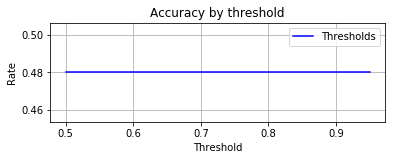

In [7]:
thresholds = []
for i in np.arange(0.5,1,0.05):
    thresholds.append(np.round(acc_threshold(y_preds,i),decimals=2))

plt.figure(1)
plt.subplot(211)
plt.plot(np.arange(0.5,1,0.05),thresholds,'b',label='Thresholds')
plt.title('Accuracy by threshold',)
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.legend(loc='best')


plt.grid(True)

In [8]:
"""Rate Of Return
x: trended data
y: predictions
r: trade if y > r
p: period
s: short if y < r
"""
def ROR(x,y,r,p,init_funds,s=False):
    dict_Info = {
        'total_costs':[],
        'total_prices':[],
        'trade_times':[],
        'date_msg':[],
        "RORs":[]
    }
    funds = init_funds
    profit=0
    total_cost=0
    total_price=0
    acc = []
    times = 0
    d_msg = ''
    for i,pre in enumerate(y[:-1]):
        price = x[(i+1)*p_days][0]
        cost = x[i*p_days][0]
        quantity = int(funds/cost)
        if pre>r:
            times+=1
            total_cost+= cost * quantity
            total_price+= price  * quantity
            funds+= (price-cost)*quantity            
            d_msg += "\nBuy Date: {} - {}\nSell Date: {} - {}\nQuantity: {}\n".format(p_date[i*p_days],cost,p_date[(i+1)*p_days],price,quantity)
            if price > cost:
                acc.append(1)
            else:
                acc.append(0)
        elif s:
            times+=1
            total_cost+= price * quantity
            total_price+= cost * quantity
            funds+= (cost-price) * quantity
            pass
        if (i+1)%p==0:
            #pass and not record the rate of prediciotn 'pre' < rate of threshold 'r'
            if total_cost != 0:
                dict_Info['total_costs'].append(total_cost*1000)
                dict_Info['total_prices'].append(total_price*1000)
                dict_Info['trade_times'].append(times)
                dict_Info['date_msg'].append(d_msg)
                dict_Info['RORs'].append((funds)/init_funds)
            times=0
            funds = init_funds
            total_cost=0
            total_price=0
            d_msg = ''
    #in case that dont have enough tra
    if len(dict_Info['RORs']) ==0:
        dict_Info['total_costs'].append(total_cost*1000)
        dict_Info['total_prices'].append(total_price*1000)
        dict_Info['trade_times'].append(times)
        dict_Info['date_msg'].append(d_msg)
        dict_Info['RORs'].append((funds)/init_funds)
    if len(acc) == 0:
        return 'No Deals.'
    print("Trend Accuracy:",np.mean(acc))
    return dict_Info,init_funds

In [9]:
d,funds = ROR(sc.inverse_transform(unperiods(X_val,p_days)),y_pred_test_lstm,0.5,12,1000)

for i in range(len(d['RORs'])):
    msg = '{}\nTotal Costs: {}\nTrade Times: {}\nInitial Funds: {}\nProfits: {}\nReturn Of Rate: {}\n'.format(d['date_msg'][i],
                                                                                    d['total_costs'][i],
                                                                                     d['trade_times'][i],
                                                                                    funds*1000,
                                                                                     d['total_prices'][i]-d['total_costs'][i],
                                                                                     d['RORs'][i])
    print(msg)
print("Average of Years ROR: {:.3f}".format(np.mean(d['RORs'])))
#print("Total cost: {:.2f}\nProfits:{:.2f}\nReturn of Rate:{:.2f}".format(t,p,p/t*100))

ValueError: too many values to unpack (expected 2)